# Section 3.4: Cox-Time Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement Cox-Time (Kvamme et al., 2019) using PyCox and PyTorch. For an overview of how Cox-Time works, please see Section 3.4 of the monograph. This Cox-Time demo builds off the DeepSurv demo (`S3.3_DeepSurv.ipynb`), so please look at that first. We again use PyCox, where the Cox-Time model is defined as the `CoxTime` Python class.

Extremely importantly, unlike how DeepSurv is implemented in PyCox, the Cox-Time implementation in PyCox uses a stochastic so-called "case-control" approximation of the loss function. Please see the paper by Kvamme et al. (2019) for details. This approximation leads to some dramatic differences in various parts of the code here (compared to our DeepSurv demo).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_raw_np, D_full_train_np, \
        X_test_raw_np, Y_test_raw_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_raw_np, Y_val_raw_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_raw_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

Because time is treated as an additional input to the neural network later, how time is scaled now matters. PyCox comes with a way to standardize time.

In [3]:
import torch
from pycox.models import CoxTime
from pycox.models.data import CoxTimeDataset

label_transform = CoxTime.label_transform()

# the code is written so that the event indicators get transformed too but they
# actually remain the same but are cast as float32
Y_train_np, D_train_np = label_transform.fit_transform(Y_train_raw_np, D_train_np)
Y_val_np, D_val_np = label_transform.transform(Y_val_raw_np, D_val_np)

Currently, PyCox requires a more complicated way of loading in data for `CoxTime`. PyCox is written so that this part of the code is "under the hood" so to speak so that if one follows the conventions of PyCox, then this sort of code does not have to be written by the user. However, since we are trying to present PyTorch models in a unified way that follows standard PyTorch conventions, we will expose some of this "under the hood" code.

To construct the dataset for use with PyTorch's DataLoader, we use the `CoxTimeDataset` class but using this requires first sorting the data by observed times. The reason why this sorting is needed by the code is that per data point (which we call the "case" point), we are going to randomly sample a "control" point (where the control point needs to have an observed time at least that of the case point). By sorting the data by observed times, it is computationally faster to figure out what are eligible control points per case point.

This "case-control" idea is used in approximating the Cox-Time loss function. Because the validation set is used for setting hyperparameter(s), and in this demo, we use the same case-control loss on the validation set, as recommended in the original PyCox Cox-Time demo, we can simply replicate the validation data multiple times to reduce variance on the validation loss values (specifically, the variance that is introduced due to the randomly sampling of control points per case point).

Note that there would be no need to use this replication strategy for the validation set if we used a different evaluation metric on the validation set that does not involve some approximation.

In [4]:
import numpy as np

np.random.seed(0)
torch.manual_seed(0)

train_sort_indices = np.argsort(Y_train_np)
train_data = CoxTimeDataset(X_train_np[train_sort_indices].astype('float32'),
                            Y_train_np[train_sort_indices].astype('float32'),
                            D_train_np[train_sort_indices].astype('int32'))

num_val_set_repeats = 5
X_val_repeated_np = np.tile(X_val_np, (num_val_set_repeats, 1))
Y_val_repeated_np = np.tile(Y_val_np, num_val_set_repeats)
D_val_repeated_np = np.tile(D_val_np, num_val_set_repeats)

val_sort_indices = np.argsort(Y_val_np)
val_data = CoxTimeDataset(X_val_repeated_np[val_sort_indices].astype('float32'),
                          Y_val_repeated_np[val_sort_indices].astype('float32'),
                          D_val_repeated_np[val_sort_indices].astype('int32'))

### Setting up the Cox-Time model and loss

In [5]:
import torch.nn as nn
from pycox.models import CoxTime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_input_features = X_train_np.shape[1] + 1  # add 1 more for time
base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1)).to(device)

# PyCox's CoxTime expects the base neural net's forward function to take in two
# separate inputs: the features and time (take a look at the forward function)
class CoxTimeBaseNeuralNetWrapper(nn.Module):
    def __init__(self, base_neural_net):
        super(CoxTimeBaseNeuralNetWrapper, self).__init__()
        self.net = base_neural_net

    def forward(self, inputs_excluding_times, times):
        inputs = torch.cat([inputs_excluding_times, times], dim=1)
        return self.net(inputs)

base_neural_net_wrapper = CoxTimeBaseNeuralNetWrapper(base_neural_net)

# specifying the label transform is important since for prediction, we basically
# need to be able to undo the standardization of time (this code is done under
# the hood by PyCox so that we don't have to worry about it, but we do need to
# specify the label transform!)
coxtime_model = CoxTime(base_neural_net_wrapper, device=device, labtrans=label_transform)
coxtime_loss = coxtime_model.loss

### Step 1 of the training procedure in Section 3.4 of the monograph: Training the log partial hazards model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [6]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for case, controls in train_loader:
        case_X_batch = case[0].squeeze(1).to(device)
        case_Y_batch = case[1].squeeze(1).to(device)
        case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

        control_X_batch = controls[0][0].squeeze(1).to(device)
        control_Y_batch = controls[0][1].squeeze(1).to(device)
        control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

        loss_batch = coxtime_loss(case_neural_net_output,
                                  control_neural_net_output)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for case, controls in train_loader:
            case_X_batch = case[0].squeeze(1).to(device)
            case_Y_batch = case[1].squeeze(1).to(device)
            case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

            control_X_batch = controls[0][0].squeeze(1).to(device)
            control_Y_batch = controls[0][1].squeeze(1).to(device)
            control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

            batch_num_points = case_X_batch.size(0)
            train_loss += coxtime_loss(case_neural_net_output,
                                       control_neural_net_output) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for case, controls in val_loader:
            case_X_batch = case[0].squeeze(1).to(device)
            case_Y_batch = case[1].squeeze(1).to(device)
            case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

            control_X_batch = controls[0][0].squeeze(1).to(device)
            control_Y_batch = controls[0][1].squeeze(1).to(device)
            control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

            batch_num_points = case_X_batch.size(0)
            val_loss += coxtime_loss(case_neural_net_output,
                                     control_neural_net_output) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 0.6940743327140808 - val loss 0.6938080191612244
Epoch 2 - train loss 0.6907305121421814 - val loss 0.6922503709793091
Epoch 3 - train loss 0.6869921684265137 - val loss 0.693767249584198
Epoch 4 - train loss 0.6828335523605347 - val loss 0.6869940161705017
Epoch 5 - train loss 0.6803634166717529 - val loss 0.6863062381744385
Epoch 6 - train loss 0.6770353317260742 - val loss 0.6803102493286133
Epoch 7 - train loss 0.6748912334442139 - val loss 0.6831167340278625
Epoch 8 - train loss 0.6687607765197754 - val loss 0.671286940574646
Epoch 9 - train loss 0.6656661033630371 - val loss 0.6715031862258911
Epoch 10 - train loss 0.6609587073326111 - val loss 0.6744487285614014
Epoch 11 - train loss 0.6567094326019287 - val loss 0.6699622273445129
Epoch 12 - train loss 0.6595966219902039 - val loss 0.6731348037719727
Epoch 13 - train loss 0.6541621685028076 - val loss 0.6562591791152954
Epoch 14 - train loss 0.6554439067840576 - val loss 0.6708393692970276
Epoch 15 - train 

<All keys matched successfully>

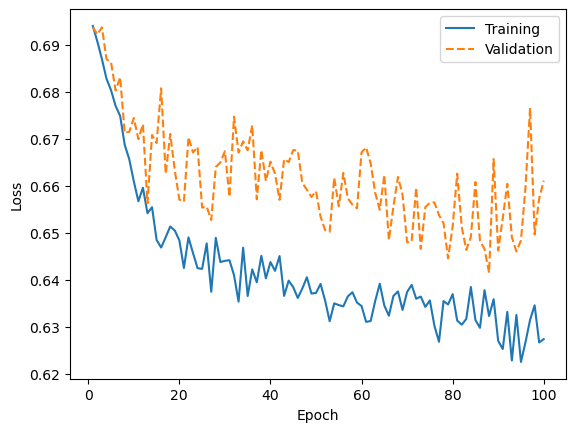

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Step 2 of the training procedure in Section 3.3 of the monograph: Fitting the baseline hazard function

In [8]:
coxtime_model.compute_baseline_hazards(input=X_train_np[train_sort_indices].astype('float32'),
                                       target=(Y_train_np[train_sort_indices].astype('float32'),
                                               D_train_np[train_sort_indices].astype('int32')))

duration
-0.849806    0.011853
-0.848020    0.025289
-0.846234    0.020463
-0.844448    0.016839
-0.842663    0.019238
               ...   
 2.759273    0.000000
 2.762845    0.000000
 2.764631    0.000000
 2.766416    0.000000
 2.768202    0.000000
Name: baseline_hazards, Length: 1444, dtype: float64

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [9]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [10]:
# predict on the test data
surv_test_df = coxtime_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
3.0,0.975527,0.971226,0.986582,0.985967,0.992237,0.993656,0.987768,0.984490,0.983593,0.995660,...,0.993348,0.986660,0.985934,0.985451,0.992206,0.985539,0.982198,0.975042,0.980223,0.984665
4.0,0.925340,0.912610,0.958521,0.956666,0.975860,0.980268,0.962157,0.952160,0.949463,0.986470,...,0.979287,0.958791,0.956548,0.955115,0.975795,0.955372,0.945294,0.923868,0.939294,0.952692
5.0,0.886662,0.867809,0.936375,0.933581,0.962795,0.969577,0.941911,0.926751,0.922699,0.979101,...,0.968043,0.936816,0.933387,0.931256,0.962728,0.931631,0.916470,0.884443,0.907405,0.927554
6.0,0.856075,0.832620,0.918516,0.914992,0.952166,0.960874,0.925563,0.906328,0.901230,0.973082,...,0.958876,0.919111,0.914728,0.912071,0.952117,0.912532,0.893426,0.853274,0.881958,0.907343
7.0,0.822449,0.794184,0.898505,0.894195,0.940154,0.951036,0.907223,0.883519,0.877297,0.966256,...,0.948498,0.899292,0.893842,0.890637,0.940148,0.891182,0.867824,0.819015,0.853733,0.884766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2026.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2027.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2028.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805


In [11]:
surv_test_np = surv_test_df.to_numpy().T
time_grid_train_np = surv_test_df.index.to_numpy()

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

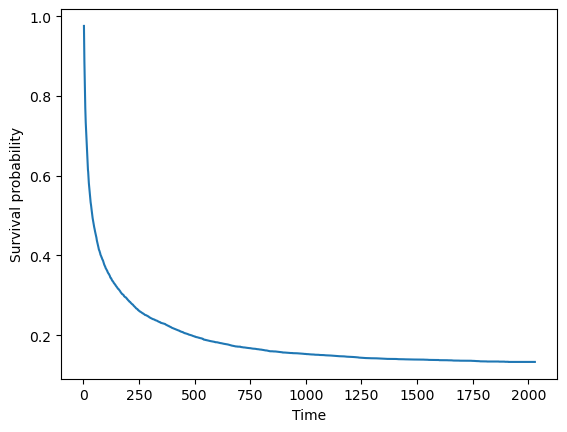

In [12]:
plt.plot(time_grid_train_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [13]:
import numpy as np
time_grid_test_np = np.unique(Y_test_raw_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [14]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_df, Y_test_raw_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6240042464655366


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [15]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_raw_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_raw_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6189888690092046
Eval time 693.0 - truncated time-dependent concordance: 0.6187114738437648
Eval time 1291.0 - truncated time-dependent concordance: 0.6131850274105245


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [16]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6773695695704807
Eval time 693.0 - time-dependent AUC: 0.7078085799435507
Eval time 1291.0 - time-dependent AUC: 0.7156318714962631


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [17]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_train_np,
                         Y_test_raw_np, D_test_np,
                         Y_train_raw_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2251993309459064


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.20330428701752654
Eval time 1291.0 - Brier score: 0.1824185628210795
Integrated Brier score: 0.1838463858192865


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [18]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [19]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 623.4871936754847


In [20]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 721.5713689377704
